In [1]:
# Standard libraries
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("figures.mplstyle")
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

import shapely

# Function and class def|intions for defining LHC/Lake geometry
from GeometryHelpers import *

In [2]:
LHC_data = pd.read_parquet('Data/LHC_data.parquet')
Lake_data = pd.read_parquet('Data/Lake_data.parquet')

# Define the LHC circle
LHC = Circle(np.array(LHC_data.loc['Point4',['X','Y','Z']]),
             np.array(LHC_data.loc['LHCb',['X','Y','Z']]),
             np.array(LHC_data.loc['Point6',['X','Y','Z']])) # last entry can be Point 2 or 6

# Fix elevation of other LHC interaction points based on LHC circle definition
for k in list(LHC_data.index):
    elev,point = LHC.find_elevation(*np.array(LHC_data.loc[k,['Latitude','Longitude']]))
    LHC_data['Elevation'][k] = elev
    LHC_data.loc[k,['X','Y','Z']] = lat_long_to_xyz(*LHC_data.loc[k,['Latitude','Longitude','Elevation']])

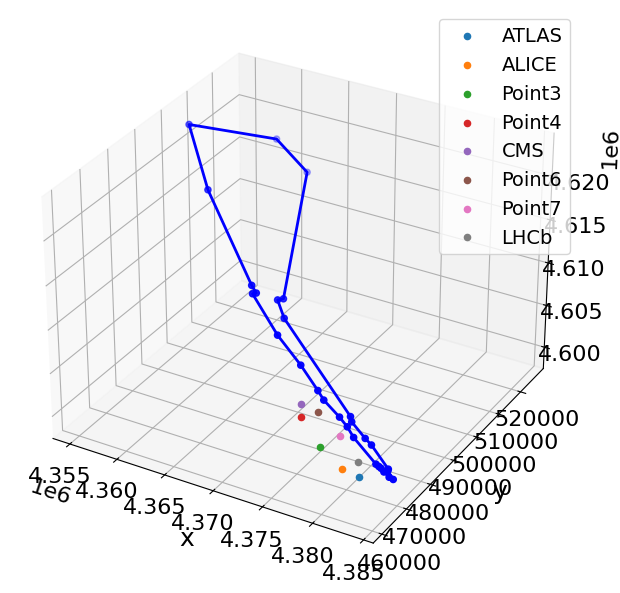

In [3]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
for k in list(LHC_data.index):
    ax.scatter(*LHC_data.loc[k,['X','Y','Z']])
ax.scatter(*np.array(Lake_data[['X','Y','Z']]).transpose(),color='blue')
# for point in Lake_data[['X','Y','Z']]:
#     ax.scatter(*point,color='blue')
ax.plot(np.append(Lake_data['X'],Lake_data['X'][0]),
        np.append(Lake_data['Y'],Lake_data['Y'][0]),
        zs=np.append(Lake_data['Z'],Lake_data['Z'][0]),
        color='blue')
plt.legend(list(LHC_data.index))
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

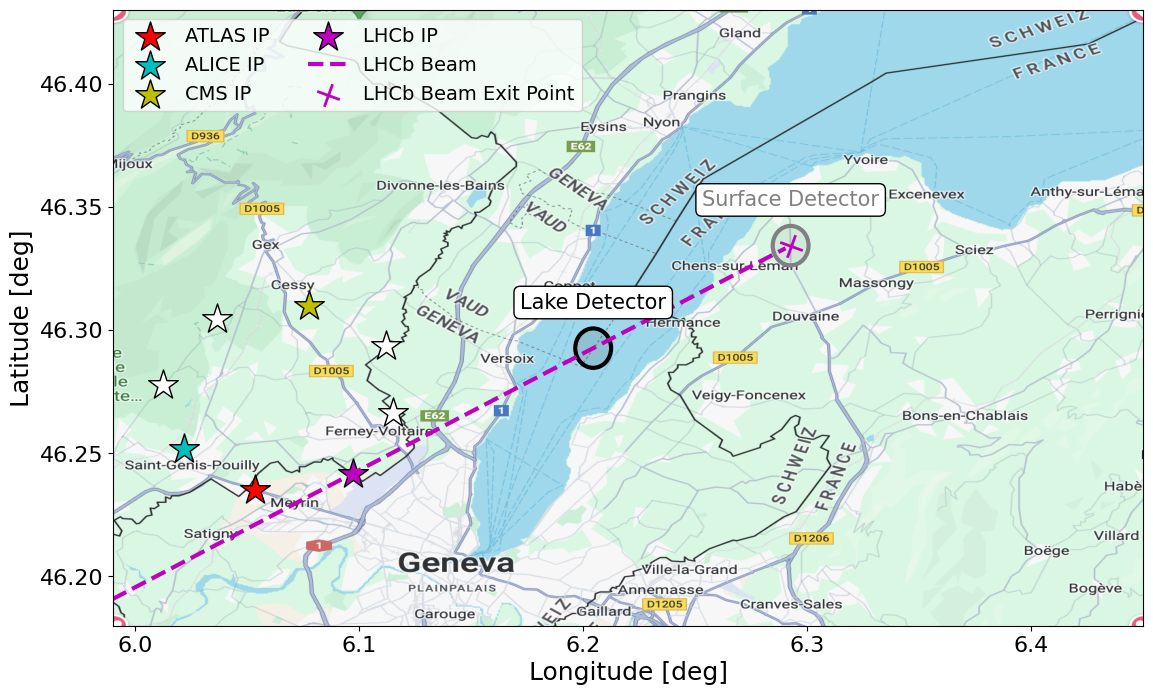

In [13]:
lat_edges = [46.18,46.43]
lon_edges = [5.99,6.45]
aspect_ratio = (lon_edges[1]-lon_edges[0])/(lat_edges[1]-lat_edges[0])
fig_height=8

fig = plt.figure(figsize=(aspect_ratio*fig_height,fig_height))
ax = plt.gca()
#ax.set_facecolor((0,1,0,0.2))

# plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
#          list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
#          color='blue',alpha=0.4,linewidth=2)
Lake_Crossings = {}
color_count = 0
colors = ["r","c","y","m"]
for k in list(LHC_data.index):
    if "Point" in k: color = "white"
    else:
        color = colors[color_count]
        color_count+=1
    Lake_Crossings[k] = []
    lines = plot_tangent_line_lat_long(LHC,
                                       np.array(LHC_data.loc[k,['X','Y','Z']]),
                                       np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                       limit=1 if 'LHCb' not in k else 18000)
    center, earth_points = lines[0] # all lines are essentially the same
    plt.scatter(center[1],
                center[0],
                marker='*',s=500,facecolor=color,edgecolor="black",label=k+" IP" if not "Point" in k else None)
    plt.plot([p[1] for p in earth_points],
             [p[0] for p in earth_points],color=color,ls='--',lw=3,label="%s Beam"%k if k=="LHCb" else None)
    if 'Point' in k: continue # don't consider points without collisions
    #if k!="ATLAS": continue
    int1,int2 = calculate_intersections_with_lake(LHC,
                                                np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                np.array(Lake_data[['Latitude','Longitude']]),
                                                limit=50000000)
    for intersections in (int1,int2):
        if(type(intersections) == shapely.geometry.MultiLineString):
            for intersection in intersections.geoms:
                for coord in list(intersection.coords):
                    Lake_Crossings[k].append(coord)
        else:
            for coord in list(intersections.coords):
                Lake_Crossings[k].append(coord)

# Pipe detector
pts = np.array([[6.19,46.281],[6.185,46.2889],[6.225,46.3075],[6.2305,46.3]])
pipe_center = (6.2044197,46.29265435)
circle = plt.Circle(pipe_center,0.008,ec="black",facecolor=mcolors.to_rgba('black', 0.1),lw=3)
plt.gca().add_patch(circle)
plt.text(pipe_center[0],1.0004*pipe_center[1],"Lake Detector",ha="center",va="center",fontsize=15,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
# rectangle = Polygon(pts,edgecolor="black",facecolor=mcolors.to_rgba('black', 0.1),lw=3)
# plt.gca().add_patch(rectangle)
# plt.text(6.17,46.293,"Pipe Detector",fontsize=15,rotation=26.5,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


# Panel detector
beam_exit = (6.292559636631747,46.33426874901515)
circle = plt.Circle(beam_exit,0.008,ec="grey",facecolor=mcolors.to_rgba('grey', 0.1),lw=3)
plt.text(beam_exit[0],1.0004*beam_exit[1],"Surface Detector",color="grey",ha="center",va="center",fontsize=15,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
plt.gca().add_patch(circle)


t = matplotlib.markers.MarkerStyle(marker="+")
t._transform = t.get_transform().rotate_deg(-20)
plt.scatter(*beam_exit,marker=t,facecolors=colors[-1],s=300,label="LHCb Beam Exit Point")


img = plt.imread("Figures/GoogleMaps.png")
plt.imshow(img,extent=[5.99,6.45,46.18,46.43],aspect=1.1)
plt.xlim(*lon_edges)
plt.ylim(*lat_edges)
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.legend(loc='upper left',ncol=2)


plt.gcf().patch.set_alpha(0.0)
plt.savefig("Figures/Nu2024_Poster/GeometryDiagram.pdf",dpi=100)
plt.show()

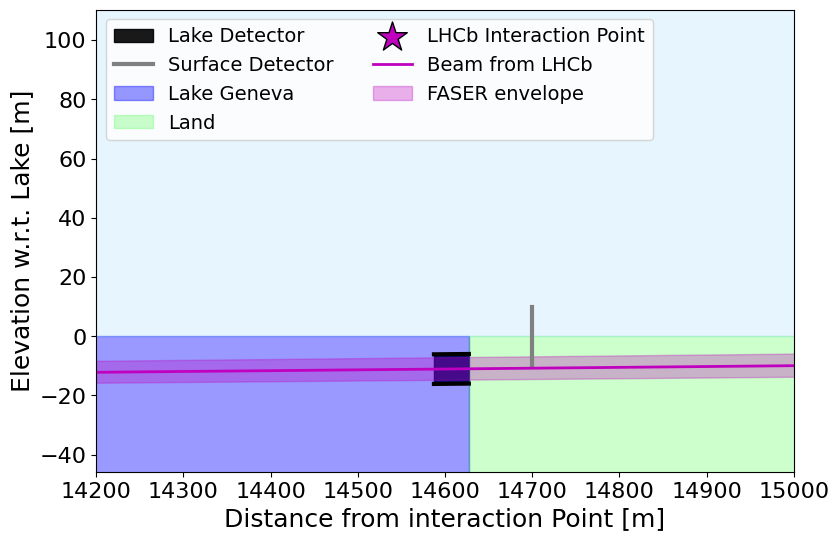

In [16]:
# elevation plot
k = "LHCb"
plot_tangent_elevation(LHC,
                      np.array(LHC_data.loc[k,['X','Y','Z']]),
                      np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                      limit=40000,
                      Lake_Crossings=Lake_Crossings[k],
                      IPlabel=k,
                      color="m",
                      pipe_position=14602,
                      panel_position=14700,
                      )
#plt.xlim(-2000,30000)
plt.xlim(14200,15000)
plt.gcf().patch.set_alpha(0.0)
plt.savefig("Figures/Nu2024_Poster/ElevationDiagram_Correlated.pdf",dpi=100)
plt.show()

Detector lat/long/elevation: [ 46.29260354   6.20431224 349.78550032]
(6878.439219609805, 10000.0)
(10000.0, 10000.0)


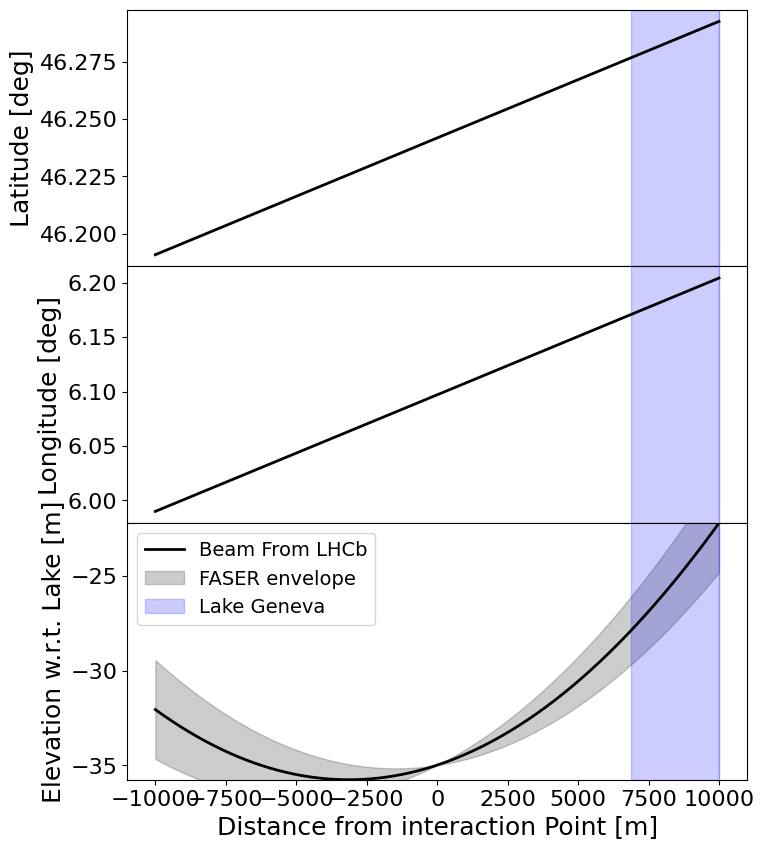

Detector lat/long/elevation: [ 46.32834576   5.95000553 638.2634503 ]
(-7508.754377188594, -10000.0)


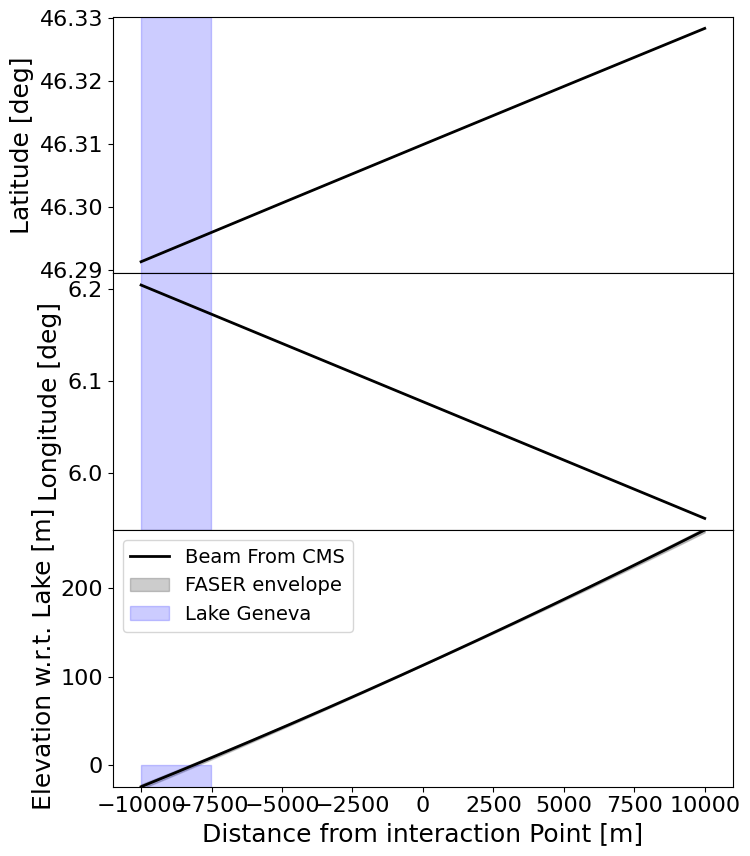

Detector lat/long/elevation: [ 46.25520354   5.92675108 518.28607829]
(-7828.914457228614, -9649.824912456228)


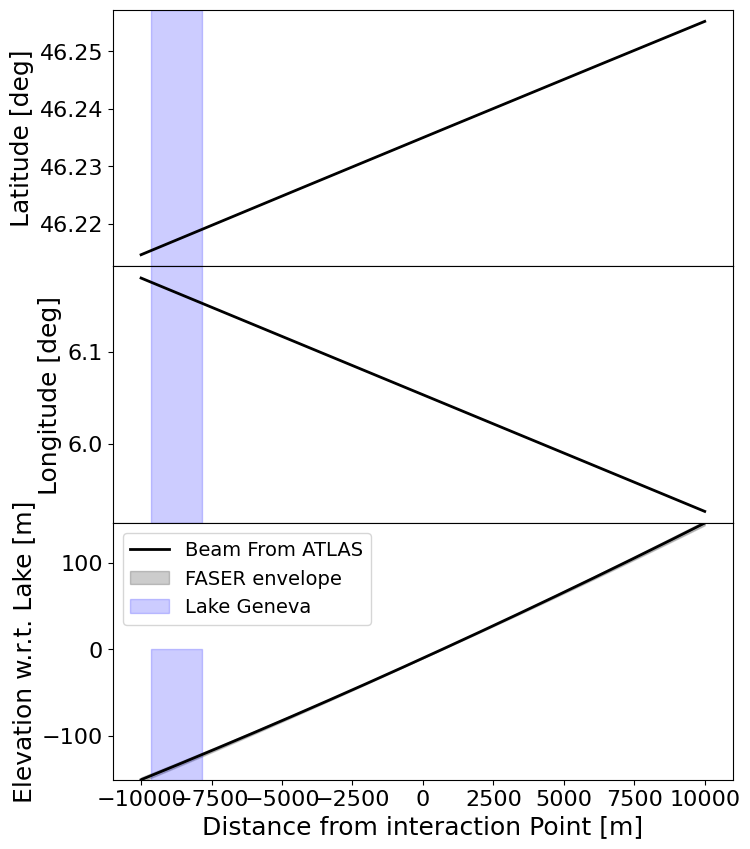

Detector lat/long/elevation: [ 46.36875685   6.04071046 637.26797406]


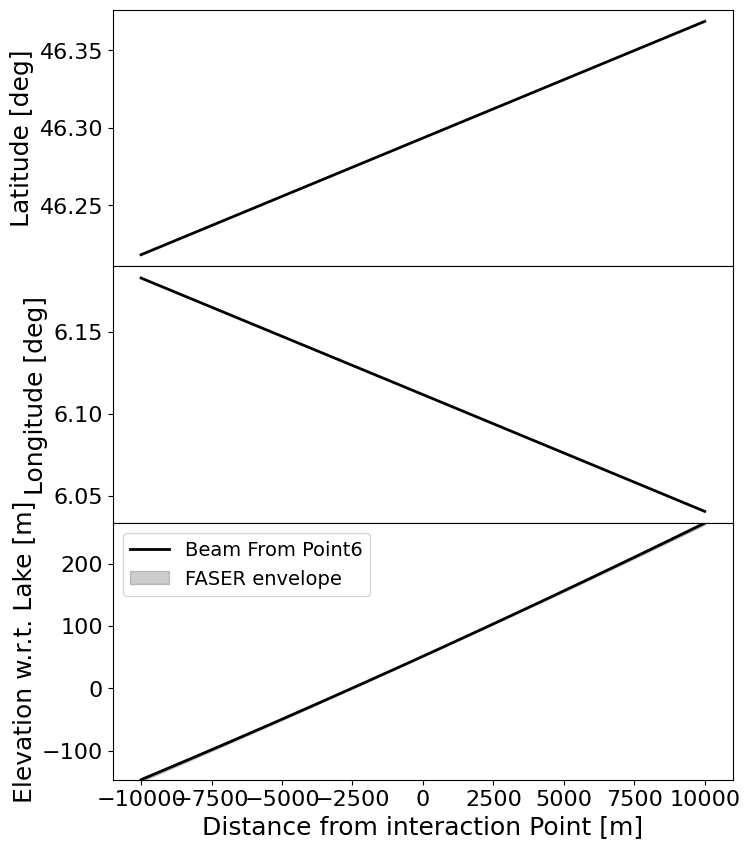

In [12]:
for k in ['LHCb','CMS','ATLAS','Point6']:
    plot_tangent_line(LHC,
                      np.array(LHC_data.loc[k,['X','Y','Z']]),
                      np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                      limit=10000,
                      Lake_Crossings=Lake_Crossings[k],
                      label='Beam From %s'%k)
    plt.show()

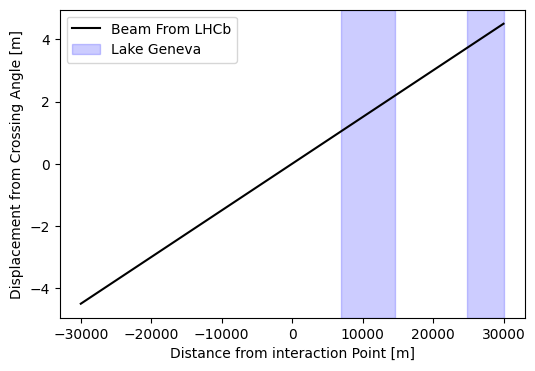

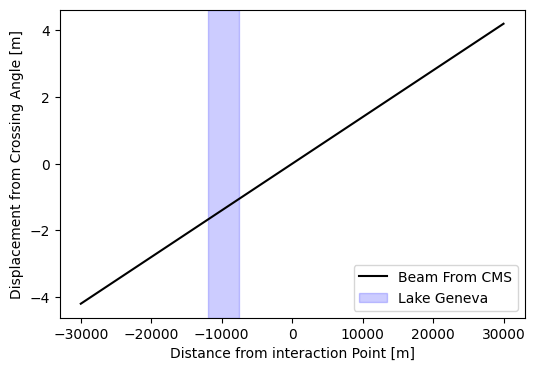

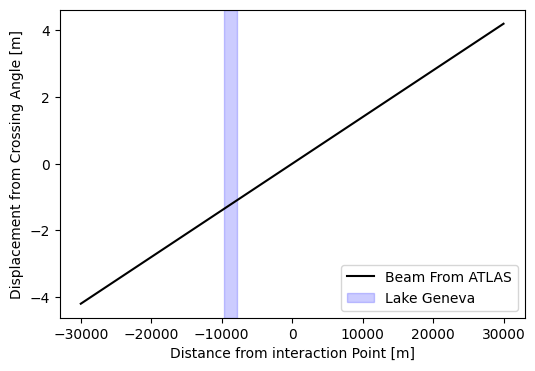

In [6]:
for k in ['LHCb','CMS','ATLAS']:
    plot_crossing_angle_impact(LHC,
                               np.array(LHC_data.loc[k,['X','Y','Z']]),
                               np.array(LHC_data.loc[k,['CrossingAngle']])/2.,
                               limit=30000,
                               Lake_Crossings=Lake_Crossings[k],
                               label='Beam From %s'%k)
    plt.show()